In [ ]:
%load_ext autoreload
%autoreload 2
from ridge_utils.DataSequence import DataSequence
import pandas as pd
import matplotlib.pyplot as plt
from os.path import dirname
import os
from tqdm import tqdm
from neuro.features import qa_questions, feature_spaces
from neuro.data import story_names, response_utils
from neuro.features.stim_utils import load_story_wordseqs, load_story_wordseqs_huge
import neuro.config
import seaborn as sns
from neuro.features.questions.gpt4 import QS_35_STABLE
import numpy as np
import joblib
from collections import defaultdict
from os.path import join
from sklearn.metrics import balanced_accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegressionCV
from neuro import analyze_helper
import dvu
from copy import deepcopy
dvu.set_style()
data_dir = join(neuro.config.repo_dir, 'data', 'decoding')

In [ ]:
def get_fmri_and_labs(data_dir, story_name='onapproachtopluto', train_or_test='test', subject='uts03'):
    '''
    Returns
    -------
    df : pd.DataFrame
        The fMRI features, with columns corresponding to the principal components
        of the fMRI data.
    labs : pd.DataFrame
        Binary labeled annotations for each of the texts
    texts: 
        The texts corresponding to the rows of df
    '''
    df = joblib.load(
        join(data_dir, subject, train_or_test, story_name + '.pkl'))
    dfs = []
    for offset in [1, 2, 3, 4]:
        df_offset = df.shift(-offset)
        df_offset.columns = [col + f'_{offset}' for col in df.columns]
        dfs.append(df_offset)
    df = pd.concat(dfs, axis=1)  # .dropna()  # would want to dropna here

    # load labels
    labs = joblib.load(
        join(data_dir, 'labels', train_or_test, story_name + '_labels.pkl'))

    # drop rows with nans
    idxs_na = df.isna().sum(axis=1).values > 0
    df = df[~idxs_na]
    labs = labs[~idxs_na]
    texts = pd.Series(df.index)
    return df, labs, texts


def concatenate_running_texts(texts, frac=1/2):
    '''When decoding, you might want to concatenate 
    the text of the current and surrounding texts
    to deal with the temporal imprecision of the fMRI signal.
    '''
    texts_before = (
        texts.shift(1)
        .str.split().apply(  # only keep second half of words
            lambda l: ' '.join(l[int(-len(l) * frac):]) if l else '')
    )

    texts_after = (
        texts.shift(-1)
        .str.split().apply(  # only keep first half of words
            lambda l: ' '.join(l[:int(len(l) * frac)]) if l else '')
    )

    return texts_before + ' ' + texts + ' ' + texts_after

# example get data
# df_orig, labs, texts = get_fmri_and_labs(data_dir)
# texts = concatenate_running_texts(texts)

# Run decode for all questions

In [ ]:
# load all the data for a single subject
data_by_subject = {}
for subject in ['uts01', 'uts02', 'uts03']:
    data = defaultdict(list)
    for train_or_test in ['test', 'train']:
        story_names_list = os.listdir(join(data_dir, subject, train_or_test))
        for story_name in story_names_list:
            df, labs, texts = get_fmri_and_labs(
                data_dir, story_name.replace('.pkl', ''), train_or_test, subject)
            data['df_' + train_or_test].append(df)
            data['labs_' + train_or_test].append(labs)
            data['texts_' + train_or_test].append(texts)

    for k in data:
        data[k] = pd.concat(data[k], axis=0)
    data_by_subject[subject] = data

In [ ]:
# set to None to keep all coefs
num_coefs_to_keep = None


def _keep_only_few_coefs(X, num_coefs_to_keep, num_features=200, num_delays=4):
    if num_coefs_to_keep is None:
        return X
    else:
        idxs_to_keep = np.arange(num_coefs_to_keep)
        idxs_to_keep = np.concatenate(
            [idxs_to_keep + i * num_features for i in range(num_delays)])
        return X[:, idxs_to_keep]


for subject in ['uts01', 'uts02', 'uts03'][::-1]:
    data = data_by_subject[subject]

    # example fit linear decoder
    r = defaultdict(list)
    for label_num in tqdm(range(data['labs_train'].shape[1])):
        X_train, y_train = data['df_train'].values, data['labs_train'].values[:, label_num]
        X_test, y_test = data['df_test'].values, data['labs_test'].values[:, label_num]
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

        # balance the binary class imbalance
        try:
            rus = RandomUnderSampler(random_state=42)
            X_train, y_train = rus.fit_resample(X_train, y_train)
            X_test, y_test = rus.fit_resample(X_test, y_test)

            # only keep 5 feats
            X_train = _keep_only_few_coefs(X_train, num_coefs_to_keep)
            X_test = _keep_only_few_coefs(X_test, num_coefs_to_keep)

            if len(y_test) < 30:
                print('too few positive labels', label_num)
                continue

            print('label', label_num,
                  data['labs_train'].columns[label_num], X_train.shape, X_test.shape)
            m = LogisticRegressionCV(random_state=42)
            m.fit(X_train, y_train)
            test_acc = m.score(X_test, y_test)
            print(
                f"""\ttest acc {test_acc:.3f}""")  # \n\tnaive acc {1 -y_test.mean():.3f}""")
            r['label'].append(data['labs_train'].columns[label_num])
            # y_pred = m.predict(X_test)
            # balanced_accuracy_score(y_test, y_pred))
            r['test_acc'].append(test_acc)
            r['num_test'].append(len(y_test))
            r['coef'].append(m.coef_.copy())

            # extra test data from another subject ##########
            test_acc_ood = []
            for subject_ood in ['uts01', 'uts02', 'uts03']:
                if subject_ood == subject:
                    continue
                X_test_ood, y_test_ood = data_by_subject[subject_ood][
                    'df_test'].values, data_by_subject[subject_ood]['labs_test'].values[:, label_num]

                # balance the binary class imbalance
                rus = RandomUnderSampler(random_state=42)
                X_test_ood, y_test_ood = rus.fit_resample(
                    X_test_ood, y_test_ood)

                X_test_ood = _keep_only_few_coefs(
                    X_test_ood, num_coefs_to_keep)

                test_acc_ood_subject = m.score(X_test_ood, y_test_ood)
                test_acc_ood.append(test_acc_ood_subject)
            r['test_acc_ood'].append(np.mean(test_acc_ood))

            print(f"""\ttest acc ood {np.mean(test_acc_ood):.3f}""")
            ###############################################

        except Exception as e:
            print(e)
            print('error for', label_num)
            continue
    r_df = pd.DataFrame(r)
    # .sort_values(
    # metric, ascending=False).reset_index()
    r_df.to_pickle(join(data_dir, f'r_df_{subject}.pkl'))

# Plot learned decoding scores

mean acc 0.6769636054332193
mean acc 0.6554084523331226
mean acc 0.6846794862854867
mean acc 0.6908028776810486


<Figure size 800x800 with 0 Axes>

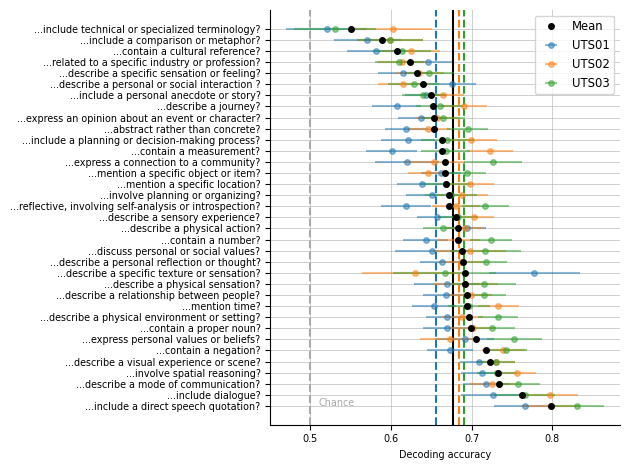

In [3]:
# plt.figure(figsize=(13, 13))
plt.figure(figsize=(8, 8))
fig, ax = plt.subplots()
colors = {
    'uts01': 'C0',
    'uts02': 'C1',
    'uts03': 'C2',
    'mean': 'black'
}
metric = 'test_acc'
# metric = 'test_acc_ood'
for subject in ['mean', 'uts01', 'uts02', 'uts03']:
    if subject == 'mean':
        dfs = [pd.read_pickle(join(data_dir, f'r_df_{subject}.pkl'))
               for subject in ['uts01', 'uts02', 'uts03']]
        r_df = pd.concat(dfs, axis=0).groupby('label').mean().reset_index()
        idx_sort = r_df[metric].sort_values(ascending=False).index
    else:
        r_df = pd.read_pickle(join(data_dir, f'r_df_{subject}.pkl'))

    r_df = r_df.loc[idx_sort]
    r_df = r_df[r_df['label'].isin(QS_35_STABLE)]

    # plot accuracy with binomial error bars
    if subject == 'mean':
        plt.errorbar(
            r_df[metric],
            range(len(r_df)),
            color='black',
            fmt='o',
            ms=4,
            zorder=1000,
            label=subject.capitalize(),
        )
        plt.axvline(r_df[metric].mean(), color=colors[subject])
    else:
        plt.errorbar(
            r_df[metric],
            range(len(r_df)),
            xerr=np.sqrt(
                r_df[metric] * (1-r_df[metric])
                / r_df['num_test']),
            alpha=0.5,
            label=subject.upper(),
            fmt='o',
            ms=4,
        )
        plt.axvline(r_df[metric].mean(),
                    linestyle='--', color=colors[subject])

    print('mean acc', r_df[metric].mean())

fs = 'x-small'
# add horizontal bars
labs = [analyze_helper.abbrev_question(q) for q in r_df['label']]
plt.yticks(range(len(r_df)), labs, fontsize=fs)
plt.xlabel(
    'Decoding accuracy', fontsize=fs)
plt.xticks(fontsize=fs)
# ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
# Get the current tick locations
xticks = ax.get_xticks()
yticks = ax.get_yticks()

# Select every other tick
# ax.set_xticks(xticks[::2])
ax.set_yticks(yticks[::2], minor=True)
ax.grid(True, which='major', linewidth=0.7, alpha=0.6)


# annotate with baseline and text label
plt.axvline(0.5, color='darkgray', linestyle='--')
plt.text(0.51, 0, 'Chance', color='darkgray', fontsize=fs, ha='left')
plt.legend(fontsize='small')
plt.tight_layout()
plt.savefig('linear_decoding.png', dpi=300)
plt.show()

# Visualize learned coefs on cortex map

In [ ]:
subject = 'uts03'

In [ ]:
pca_comps = joblib.load(f'{subject}/pca_components.pkl')
# vertically stack pca_comps 4 times
pca_comps = np.vstack([pca_comps]*4)

In [ ]:
def quickshow(X: np.ndarray, subject="UTS03", fname_save=None, title=None):
    import cortex

    """
    Actual visualizations
    Note: for this to work, need to point the cortex config filestore to the `ds003020/derivative/pycortex-db` directory.
    This might look something like `/home/chansingh/mntv1/deep-fMRI/data/ds003020/derivative/pycortex-db/UTS03/anatomicals/`
    """
    vol = cortex.Volume(X, subject, xfmname=f"{subject}_auto")
    # , with_curvature=True, with_sulci=True)
    vabs = max(abs(vol.data.min()), abs(vol.data.max()))
    vol.vmin = -vabs
    vol.vmax = vabs
    # fig = plt.figure()
    # , vmin=-vabs, vmax=vabs)
    cortex.quickshow(vol, with_rois=True, cmap="PuBu")
    # fig = plt.gcf()
    # add title
    # fig.axes[0].set_title(title, fontsize='xx-small')
    if fname_save is not None:
        plt.savefig(fname_save)
        # plt.savefig(fname_save.replace(".pdf", ".png"))
        plt.close()

In [ ]:
for i in range(len(r_df)):
    pc_coef = r_df.iloc[i]['coef']
    voxel_coefs = (pc_coef @ pca_comps).squeeze()
    quickshow(voxel_coefs, fname_save=join(
        'flatmaps_decoding', f'{r_df.iloc[i]["label"]}.pdf'))